In [5]:
import copy
import sys
import time
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

warnings.filterwarnings("ignore")


Parse the Data

In [6]:
from utils import get_data

problem = 'lra'
case = 1
study = 6

var = None
if problem != 'three_group_sphere':
    var = 'power_density'

print("Loading and formating the data...")
t_start = time.time()
if problem == 'infinite_slab':
    dataset = get_data(problem, case, study)
else:
    dataset = get_data(problem, study)
X = dataset.create_dataset_matrix(var)
Y = dataset.parameters
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")


Loading and formating the data...
Loading the data took 102.425117 s


Define the QoI function

In [7]:
if problem == 'three_group_sphere':
    def QoI(x):
        dmd = DMD(svd_rank=4, opt=True)
        dmd.fit(x)
        omegas = np.log(dmd.eigvals)/dt
        return omegas[np.argmax(omegas.real)]

elif problem == 'infinite_slab':
    def QoI(x):
        return np.sum(x[-1])*2.0

elif problem == 'twigl':
    def QoI(x):
        return np.sum(x[-1])*16.0

elif problem == 'lra':
    def QoI(x):
        return np.max(x[np.argmax(np.max(x, axis=1))])

else:
    raise NotImplementedError(f"QoI function not implemented for {problem}")


Performing Model Validation

Performing validation...
	Mean of Mean Fold Errors:	1.013e-03
	Maximum Mean Fold Errors:	3.008e-03
	Minimum Mean Fold Errors:	4.076e-04
	Maximum of Maximum Fold Errors:	5.201e-02
	Minimum of Minimum Fold Errors:	1.301e-05
Validation took 2.711 s.
QoI:	22529.704982696247
QoI:	15722.738336259808


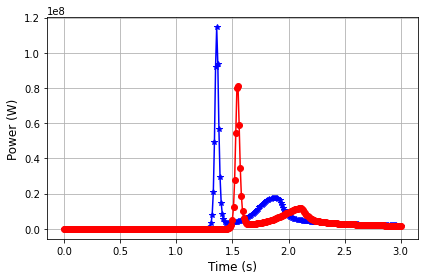

In [15]:
from pyROMs import POD, DMD
from sklearn.model_selection import KFold

n_splits = 10
interior_only = False
seed = 12

tau = 1.0e-8
if problem == 'three_group_sphere':
    interp = 'rbf_gaussian'
    epsilon = 200.0
elif problem == 'infinite_slab':
    interp = 'rbf'
    epsilon = 1.0
elif problem == 'twigl':
    interp = 'rbf'
    epsilon = 20.0
else:
    interp = 'rbf'
    epsilon = 100.0

print("Performing validation...")
t_start = time.time()
cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
pod = POD(svd_rank=1.0-tau)
errors = {'mean': [], 'max': [], 'min': []}
for train, test in cv.split(X, Y):
    pod = pod.fit(X[train], Y[train], interp, epsilon=epsilon)
    X_pod = pod.predict(Y[test])

    X_test = dataset.unstack_simulation_vector(X[test])
    X_pod = dataset.unstack_simulation_vector(X_pod)

    fold_error = np.zeros(len(test))
    for i in range(len(test)):
        qoi_test = QoI(X_test[i])
        qoi_pod = QoI(X_pod[i])
        fold_error[i] = abs(qoi_test-qoi_pod)/abs(qoi_test)
    errors['mean'].append(np.mean(fold_error)/len(test))
    errors['max'].append(np.max(fold_error))
    errors['min'].append(np.min(fold_error))
t_end = time.time()
print(f"\tMean of Mean Fold Errors:\t{np.mean(errors['mean']):.3e}")
print(f"\tMaximum Mean Fold Errors:\t{np.max(errors['mean']):.3e}")
print(f"\tMinimum Mean Fold Errors:\t{np.min(errors['mean']):.3e}")
print(f"\tMaximum of Maximum Fold Errors:\t{np.max(errors['max']):.3e}")
print(f"\tMinimum of Minimum Fold Errors:\t{np.min(errors['min']):.3e}")
print(f"Validation took {t_end-t_start:.3f} s.")

plt.figure()
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Power (W)", fontsize=12)

# Get max peak power per simulation
peak_power = []
for s in range(len(dataset.simulations)):
    simulation = dataset.simulations[s]
    P_max = np.max(simulation.powers)
    peak_power.append(P_max)

# Plot min/max max peak powers over the space
styles = ['-*b', '-or']
argmin = int(np.argmin(peak_power))
argmax = int(np.argmax(peak_power))
for i, s in enumerate([argmax, argmin]):
    simulation = dataset.simulations[s]
    P = simulation.powers
    print(f"QoI:\t{QoI(simulation.power_densities)}")
    plt.plot(dataset.times, P, styles[i])
plt.grid(True)
plt.tight_layout()

Fit the ROM to All Data

Fitting the ROM to all available data...
Fitting took 0.295 s.


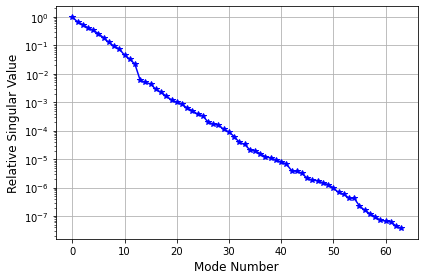

In [16]:
print("Fitting the ROM to all available data...")
t_start = time.time()
pod.fit(X, Y, interp, epsilon=epsilon)
t_end = time.time()
print(f"Fitting took {t_end-t_start:.3f} s.")

pod.plot_singular_values()

Generate Random Samples and Query the ROM


Starting ROM queries...
ROM queries took 79.907 s.
Mean:	1.271e+04.
STD:	2.478e+03


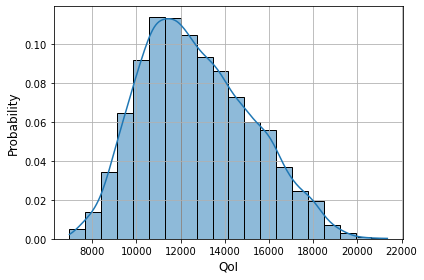

In [17]:
import seaborn as sb
from matplotlib.pyplot import Figure, Axes

n_samples = int(1.0e4)

rng = np.random.default_rng()
bounds = dataset.parameter_bounds
samples = np.zeros((n_samples, dataset.n_parameters))
for p in range(samples.shape[1]):
    samples[:, p] = rng.uniform(*bounds[p], n_samples)

qoi = np.zeros((n_samples,))
dt = np.diff(dataset.times)[0]

# POD predictions
print("Starting ROM queries...")
t_start = time.time()
X_pod = pod.predict(samples)
X_pod = dataset.unstack_simulation_vector(X_pod)
for i in range(n_samples):
    qoi[i] = QoI(X_pod[i])
t_end = time.time()
print(f"ROM queries took {t_end-t_start:.3f} s.")

print(f"Mean:\t{np.mean(qoi):.3e}.")
print(f"STD:\t{np.std(qoi):.3e}")

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
xlabel = r"QoI"
ylabel = "Probability"
sb.histplot(qoi, stat='probability', bins=20, kde=True, ax=ax)
ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)
ax.grid(True)
plt.tight_layout()

base = "/Users/zacharyhardy/Documents/phd/dissertation/" \
       "dissertation/figures/chapter10"
if problem == 'three_group_sphere':
    filename = f"{base}/alpha_rom.pdf"
elif problem == 'infinite_slab':
    filename = f"{base}/inf_slab_final_power.pdf"
elif problem == 'twigl':
    filename = f"{base}/twigl_final_power.pdf"
elif problem == 'lra':
    filename = f"{base}/lra_peak_power.pdf"
else:
    raise ValueError("Huh?")

dirname = '/'.join(filename.split('/')[:-1])
if not os.path.isdir(dirname):
    os.makedirs(dirname)
plt.savefig(filename)